Reloading Tuner from my_dir\intro_to_kt\tuner0.json


6/6 [==============================] - 24s 4s/step - loss: 0.8580 - accuracy: 0.6333
The accuracy of the classification is: 63.33%


6/6 [==============================] - 27s 5s/step
              precision    recall  f1-score   support

   collision       0.67      0.71      0.69        58
       cutin       0.46      0.47      0.47        53
        safe       0.74      0.70      0.72        69

    accuracy                           0.63       180
   macro avg       0.62      0.62      0.62       180
weighted avg       0.64      0.63      0.63       180

[[41 15  2]
 [13 25 15]
 [ 7 14 48]]
1/1 [==============================] - 0s 281ms/step
The new image is classified as: cutin
Estimated TTC: 29.92 seconds
Prediction scores: [0.20748185 0.53412795 0.25839022]


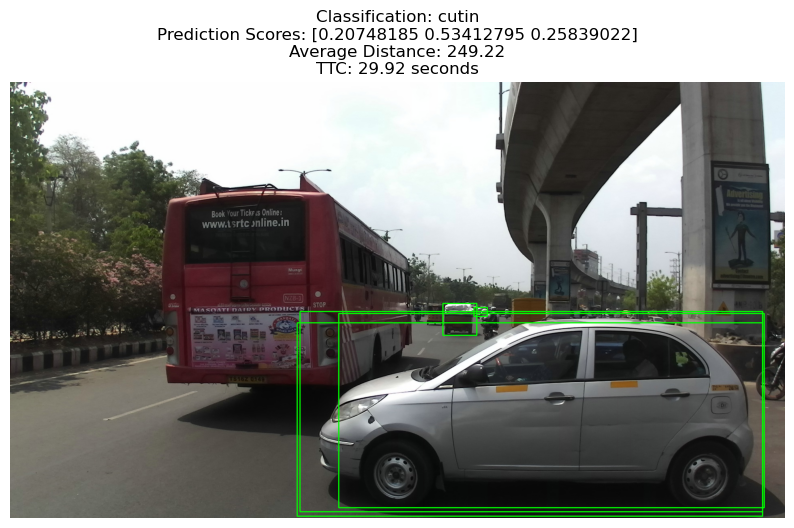

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
import keras_tuner as kt
import matplotlib.pyplot as plt

# Load YOLOv3 model
def load_yolo():
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return net, output_layers, classes

net, output_layers, classes = load_yolo()

def load_image(image_path):
    return cv2.imread(image_path)

def preprocess_image(image, target_size=(224, 224)):
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def process_folder(base_folder, label, data, target_size=(224, 224)):
    folder_path = os.path.join(base_folder, label)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            image = load_image(image_path)
            if image is None:
                continue
            processed_image = preprocess_image(image, target_size)
            data.append((processed_image, label))

def detect_vehicles(image):
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)
    vehicle_boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if classes[class_id] == 'car' and confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                vehicle_boxes.append([x, y, w, h])
    return vehicle_boxes

def calculate_distances(boxes):
    distances = []
    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            x1, y1, w1, h1 = boxes[i][:4]
            x2, y2, w2, h2 = boxes[j][:4]
            distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
            distances.append(distance)
    return distances

def build_transfer_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(3, activation='softmax'))
    
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def classify_new_image(image_path, model, label_map):
    image = load_image(image_path)
    if image is None:
        return "Unknown", None, None, None, None
    
    vehicle_boxes = detect_vehicles(image)
    if len(vehicle_boxes) < 2:
        return "Unknown", None, None, None, None
    
    distances = calculate_distances(vehicle_boxes)
    avg_distance = np.mean(distances)

    processed_image = preprocess_image(image)
    image_array = np.expand_dims(processed_image, axis=0)
    image_array = image_array / 255.0  # Normalize pixel values

    prediction = model.predict(image_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Assuming a relative speed of 8.33 m/s (30 km/h)
    relative_speed = 8.33
    ttc = avg_distance / relative_speed if relative_speed != 0 else float('inf')

    return label_map[predicted_class], prediction[0], vehicle_boxes, avg_distance, ttc

def visualize_classification(image_path, classification, prediction_scores, vehicle_boxes, avg_distance, ttc, output_path):
    image = load_image(image_path)
    for box in vehicle_boxes:
        x, y, w, h = box
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Classification: {classification}\nPrediction Scores: {prediction_scores}\nAverage Distance: {avg_distance:.2f}\nTTC: {ttc:.2f} seconds')
    plt.axis('off')
    plt.savefig(output_path)
    plt.show()

def main(base_folder, new_image_path, output_image_path):
    folders = ['safe', 'cutin', 'collision']
    data = []
    
    target_size = (224, 224)
    for label in folders:
        process_folder(base_folder, label, data, target_size=target_size)
    
    images, labels = zip(*data)
    images = np.array(images)
    labels = np.array(labels)
    
    # Scale images
    images = images / 255.0  # Normalize pixel values

    # Encode labels
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    datagen.fit(X_train)

    # Hyperparameter tuning
    tuner = kt.RandomSearch(
        build_transfer_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='my_dir',
        project_name='intro_to_kt'
    )

    tuner.search(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))
    
    best_model = tuner.get_best_models(num_models=1)[0]

    # Evaluate the model
    loss, accuracy = best_model.evaluate(X_test, y_test)
    print(f"The accuracy of the classification is: {accuracy:.2%}")

    # Save the model
    model_filename = 'best_distance_classification_model.keras'
    best_model.save(model_filename)

    # Load the model
    model = load_model(model_filename)

    # Evaluate with a confusion matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    print(classification_report(y_true_classes, y_pred_classes, target_names=lb.classes_))
    print(confusion_matrix(y_true_classes, y_pred_classes))

    # Classify the new image
    label_map = {i: label for i, label in enumerate(lb.classes_)}
    classification, prediction_scores, vehicle_boxes, avg_distance, ttc = classify_new_image(new_image_path, model, label_map)
    print(f"The new image is classified as: {classification}")
    print(f"Estimated TTC: {ttc:.2f} seconds")

    if prediction_scores is not None:
        print(f"Prediction scores: {prediction_scores}")
        visualize_classification(new_image_path, classification, prediction_scores, vehicle_boxes, avg_distance, ttc, output_image_path)

if __name__ == "__main__":
    base_folder = ''  # Set the base folder path
    new_image_path = '621.jpeg'  # Set the path to the new image
    output_image_path = 'output_image.png'  # Set the path to save the output image
    main(base_folder, new_image_path, output_image_path)
